# Clustering and Classifition with PySpark



## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

In this project, goal is experiment clustering and classification with PySpark. Aim of this project is to identify the types of beans. We will cluster and classify the data according to their types (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz, Sira).




##### Installing Pyspark

In [1]:
conda install pyspark

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - pyspark


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> pkgs/main::ca-certificates-2022.3.29-haa95532_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2021.10.8-py38ha~ --> pkgs/main::certifi-2021.10.8-py38haa95532_2
  conda              conda-forge::conda-4.12.0-py38haa244f~ --> pkgs/main::conda-4.12.0-py38haa95532_0
  openssl            conda-forge::openssl-1.1.1n-h8ffe710_0 --> pkgs/main::openssl-1.1.1n-h2bbff1b_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Rolling back transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(143): Could not remove or rename C:\ProgramData\Anaconda3\Library\bin\libssl-1_1-x64.dll.  Please remove this file manually (you may need to reboot to free file handles)
ERROR conda.core.link:_execute(730): An error occurred while installing package 'defaults::openssl-1.1.1n-h2bbff1b_0'.
WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(143): Could not remove or rename C:\ProgramData\Anaconda3\Library\bin\libssl-1_1-x64.dll.  Please remove this file manually (you may need to reboot to free file handles)

[Errno 13] Permission denied: 'C:\\ProgramData\\Anaconda3\\Library\\bin\\libssl-1_1-x64.dll'
()



In [2]:
conda install -c conda-forge findspark

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

import pyspark
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import MinMaxScaler,MinMaxScalerModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans,KMeansModel
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,recall_score,precision_score

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [6]:
df = pd.read_csv("data.csv") #reading the data
sqlContext = SQLContext(sc)
OD = sqlContext.read.options(header=True,inferSchema=True).csv("data.csv")
print(type(OD))
print((OD.count(), len(OD.columns)))

<class 'pyspark.sql.dataframe.DataFrame'>
(13611, 17)


Our dataframe is pyspark dataframe and dataframe contains 13611 rows 17 columns

In [7]:
from pyspark.sql.functions import isnan, when, count, col
OD.select([count(when(col(c).isNull(), c)).alias(c) for c in OD.columns]).show()
print(OD.show())
print(OD.printSchema())

+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|Extent|Solidity|roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|   0|        0|              0|              0|           0|           0|         0|            0|     0|       0|        0|          0|           0|           0|           0|           0|    0|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+

+-----+---------+--

There is no NA values in dataset. Class column is a string type and the others are numeric values.

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [8]:
print((OD.count(), len(OD.columns)))
OD = OD.dropDuplicates()
print((OD.count(), len(OD.columns)))
OD = OD.replace(to_replace={'SEKER': '0', 'BARBUNYA': '1','BOMBAY': '2', 'CALI': '3','HOROZ': '4', 'SIRA': '5','DERMASON': '6'}, subset=['Class'])
from pyspark.sql.functions import col, when
 
print(OD.show())
pandas_OD = OD.toPandas()
pandas_OD.head()

(13611, 17)
(13543, 17)
+------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|  Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| 36986|  693.771|    232.7137695|    202.5916367| 1.148683989| 0.492059713|     37350|  217.0069994|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|    0|
| 40587|   746.02|     262.969584|    196.7418707| 1.336622362| 0.663524591|     41053|  227.3256989|0.777528736| 0.98864882|0.916422776|0.86445

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,36986,693.771,232.713770,202.591637,1.148684,0.492060,37350,217.006999,0.771748,0.990254,0.965639,0.932506,0.006292,0.002935,0.869568,0.998858,0
1,40587,746.020,262.969584,196.741871,1.336622,0.663525,41053,227.325699,0.777529,0.988649,0.916423,0.864456,0.006479,0.002232,0.747285,0.998837,0
2,47003,821.301,300.190765,200.111284,1.500119,0.745403,47681,244.634581,0.775781,0.985780,0.875650,0.814930,0.006387,0.001738,0.664112,0.996246,1
3,65526,992.787,361.204135,231.623566,1.559445,0.767329,66422,288.843027,0.697560,0.986510,0.835432,0.799667,0.005512,0.001390,0.639467,0.997214,1
4,67856,1036.144,372.724472,232.567681,1.602649,0.781451,69052,293.933568,0.810202,0.982680,0.794251,0.788608,0.005493,0.001310,0.621903,0.996692,1


Dataset contains some repetitive rows. 68 duplicate rows removed and our data now has a 13543 rows. Also Class column string values replaced with numeric values.

In [9]:
data = pandas_OD.values[:, :-1]
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
data = trans.fit_transform(data)
# convert the array back to a dataframe
pandas_ND = pd.DataFrame(data)
pandas_ND["Class"] = pandas_OD["Class"]
pandas_ND.rename(columns={0:'Area', 1:'Perimeter', 2:'MajorAxisLength', 3:'MinorAxisLength', 4:'AspectRation', 5:'Eccentricity', 6:'ConvexArea', 7:'EquivDiameter',8:'Extent',9:'Solidity',10:'roundness',11:'Compactness',12:'ShapeFactor1', 13:'ShapeFactor2', 14:'ShapeFactor3', 15:'ShapeFactor4',16:'Class'}, inplace=True)
ND = spark.createDataFrame(pandas_ND)
pandas_ND.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,0.070736,0.115727,0.088450,0.237140,0.088098,0.394397,0.068704,0.136631,0.696194,0.941362,0.950015,0.841959,0.457951,0.764506,0.813617,0.983203,0
1,0.086112,0.151499,0.142939,0.219817,0.221820,0.642009,0.083969,0.161914,0.714791,0.920077,0.851791,0.645695,0.482350,0.537831,0.596968,0.982799,0
2,0.113507,0.203039,0.209973,0.229795,0.338152,0.760251,0.111292,0.204324,0.709168,0.882052,0.770420,0.502857,0.470291,0.378407,0.449610,0.933018,1
3,0.192599,0.320444,0.319856,0.323114,0.380363,0.791913,0.188550,0.312643,0.457557,0.891729,0.690155,0.458835,0.356355,0.266473,0.405948,0.951607,1
4,0.202548,0.350127,0.340604,0.325910,0.411104,0.812307,0.199392,0.325116,0.819888,0.840944,0.607968,0.426940,0.353813,0.240677,0.374829,0.941585,1


MinMax normalization applied to data and ND created.

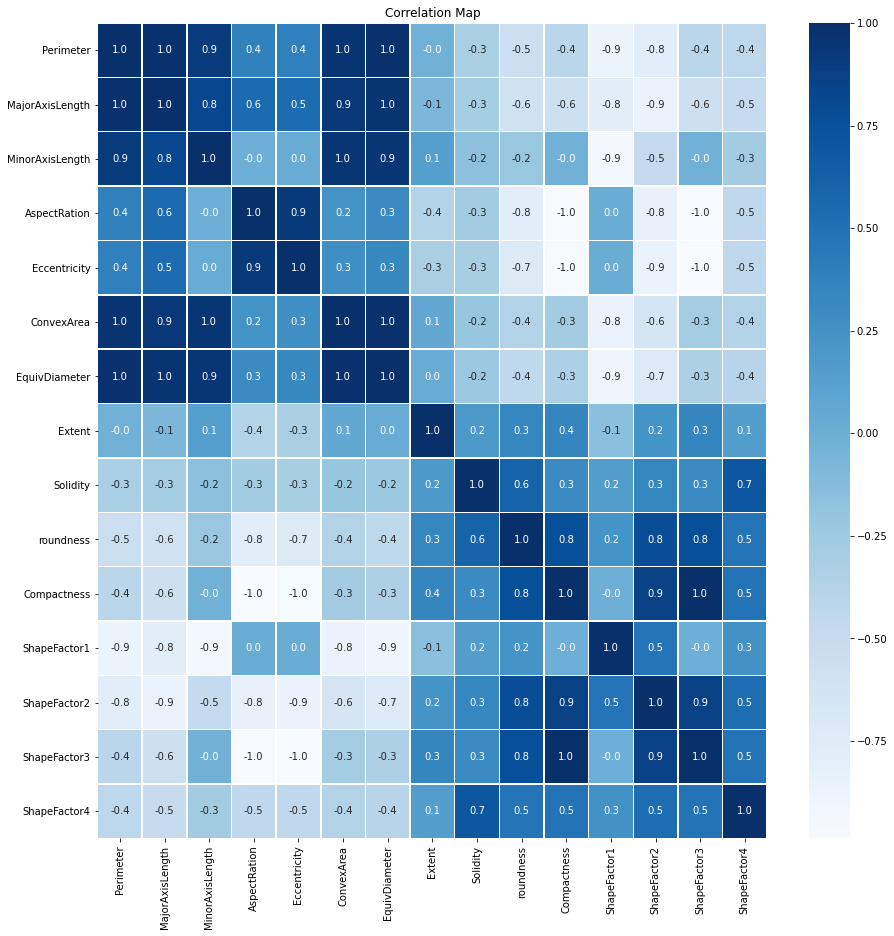

In [35]:
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(pandas_OD.iloc[:,1:].corr(),annot= True,linewidths=0.5,fmt = ".1f", ax=ax, cmap="Blues")
plt.title('Correlation Map')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In [10]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

columns = OD.columns[:-1]
print(columns)

['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


To apply desired methods, all features combined in a new column "features"

In [11]:
assembler = VectorAssembler(inputCols = columns, 
                            outputCol="features")
OD = assembler.transform(OD)
OD.show(vertical=True)

-RECORD 0-------------------------------
 Area            | 36986                
 Perimeter       | 693.771              
 MajorAxisLength | 232.7137695          
 MinorAxisLength | 202.5916367          
 AspectRation    | 1.148683989          
 Eccentricity    | 0.492059713          
 ConvexArea      | 37350                
 EquivDiameter   | 217.0069994          
 Extent          | 0.771747522          
 Solidity        | 0.990254351          
 roundness       | 0.965639328          
 Compactness     | 0.932506056          
 ShapeFactor1    | 0.006291942          
 ShapeFactor2    | 0.00293475           
 ShapeFactor3    | 0.869567545          
 ShapeFactor4    | 0.998858317          
 Class           | 0                    
 features        | [36986.0,693.771,... 
-RECORD 1-------------------------------
 Area            | 40587                
 Perimeter       | 746.02               
 MajorAxisLength | 262.969584           
 MinorAxisLength | 196.7418707          
 AspectRation   

In [12]:
kmeans = KMeans(featuresCol="features", k=7,seed=42)
model = kmeans.fit(OD)
model.transform(OD).groupBy("Prediction").count().show()

+----------+-----+
|Prediction|count|
+----------+-----+
|         1|  251|
|         6|  177|
|         3| 1800|
|         5|   98|
|         4| 4396|
|         2| 4625|
|         0| 2196|
+----------+-----+



In [13]:
COD = model.transform(OD).drop("features")
#COD=COD.withColumn('prediction',COD['prediction'].cast("float").alias('prediction'))
COD = COD.withColumnRenamed('prediction', 'Cluster')
COD.show(vertical=True)

-RECORD 0----------------------
 Area            | 36986       
 Perimeter       | 693.771     
 MajorAxisLength | 232.7137695 
 MinorAxisLength | 202.5916367 
 AspectRation    | 1.148683989 
 Eccentricity    | 0.492059713 
 ConvexArea      | 37350       
 EquivDiameter   | 217.0069994 
 Extent          | 0.771747522 
 Solidity        | 0.990254351 
 roundness       | 0.965639328 
 Compactness     | 0.932506056 
 ShapeFactor1    | 0.006291942 
 ShapeFactor2    | 0.00293475  
 ShapeFactor3    | 0.869567545 
 ShapeFactor4    | 0.998858317 
 Class           | 0           
 Cluster         | 4           
-RECORD 1----------------------
 Area            | 40587       
 Perimeter       | 746.02      
 MajorAxisLength | 262.969584  
 MinorAxisLength | 196.7418707 
 AspectRation    | 1.336622362 
 Eccentricity    | 0.663524591 
 ConvexArea      | 41053       
 EquivDiameter   | 227.3256989 
 Extent          | 0.777528736 
 Solidity        | 0.98864882  
 roundness       | 0.916422776 
 Compact

In [14]:
assembler_nd = VectorAssembler(inputCols = columns, 
                            outputCol="features")
ND = assembler_nd.transform(ND)
ND.show(vertical=True)

-RECORD 0-------------------------------
 Area            | 0.07073562315325622  
 Perimeter       | 0.11572714314468924  
 MajorAxisLength | 0.08844990448992979  
 MinorAxisLength | 0.23714048068298166  
 AspectRation    | 0.08809802924680932  
 Eccentricity    | 0.3943965479427062   
 ConvexArea      | 0.06870395791851659  
 EquivDiameter   | 0.13663086278294767  
 Extent          | 0.6961942161308556   
 Solidity        | 0.9413619216616631   
 roundness       | 0.9500145393687995   
 Compactness     | 0.8419591267703701   
 ShapeFactor1    | 0.45795093961337424  
 ShapeFactor2    | 0.764505516796778    
 ShapeFactor3    | 0.8136174995777011   
 ShapeFactor4    | 0.9832027886107397   
 Class           | 0                    
 features        | [0.07073562315325... 
-RECORD 1-------------------------------
 Area            | 0.08611163299116976  
 Perimeter       | 0.1514985958152419   
 MajorAxisLength | 0.14293945824165621  
 MinorAxisLength | 0.2198173795934193   
 AspectRation   

In [15]:
kmeans_nd = KMeans(featuresCol="features", k=7,seed=42)
model_nd = kmeans_nd.fit(ND)
model_nd.transform(ND).groupBy("Prediction").count().show()

+----------+-----+
|Prediction|count|
+----------+-----+
|         1| 5656|
|         6|  273|
|         3|  251|
|         5| 2296|
|         4| 2095|
|         2| 1854|
|         0| 1118|
+----------+-----+



In [16]:
CND = model_nd.transform(ND).drop("features")
CND = CND.withColumnRenamed('prediction', 'Cluster')
CND.show(vertical=True)

-RECORD 0------------------------------
 Area            | 0.07073562315325622 
 Perimeter       | 0.11572714314468924 
 MajorAxisLength | 0.08844990448992979 
 MinorAxisLength | 0.23714048068298166 
 AspectRation    | 0.08809802924680932 
 Eccentricity    | 0.3943965479427062  
 ConvexArea      | 0.06870395791851659 
 EquivDiameter   | 0.13663086278294767 
 Extent          | 0.6961942161308556  
 Solidity        | 0.9413619216616631  
 roundness       | 0.9500145393687995  
 Compactness     | 0.8419591267703701  
 ShapeFactor1    | 0.45795093961337424 
 ShapeFactor2    | 0.764505516796778   
 ShapeFactor3    | 0.8136174995777011  
 ShapeFactor4    | 0.9832027886107397  
 Class           | 0                   
 Cluster         | 5                   
-RECORD 1------------------------------
 Area            | 0.08611163299116976 
 Perimeter       | 0.1514985958152419  
 MajorAxisLength | 0.14293945824165621 
 MinorAxisLength | 0.2198173795934193  
 AspectRation    | 0.2218202277375354  


KMeans used for clustering. 

## Clustering results<a class="anchor" id="clustering"></a>

In [17]:
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[6.13387951e+04 9.74306888e+02 3.74734870e+02 2.10592396e+02
 1.80058280e+00 8.17617334e-01 6.22917250e+04 2.79213400e+02
 7.30861550e-01 9.84775752e-01 8.12196447e-01 7.48143149e-01
 6.14337550e-03 1.19513878e-03 5.62626198e-01 9.92831656e-01]
[1.76467618e+05 1.60501012e+03 6.03792202e+02 3.75566548e+02
 1.61099735e+00 7.79666729e-01 1.78850458e+05 4.73875119e+02
 7.77214216e-01 9.86701170e-01 8.60958322e-01 7.85912101e-01
 3.42461398e-03 8.08341869e-04 6.18437686e-01 9.91463254e-01]
[4.48145366e+04 7.99596325e+02 2.99632154e+02 1.92155355e+02
 1.57454702e+00 7.44873889e-01 4.53545256e+04 2.38637012e+02
 7.46417434e-01 9.88169869e-01 8.82962591e-01 8.03193577e-01
 6.68889352e-03 1.75057020e-03 6.49346797e-01 9.95706138e-01]
[7.90870606e+04 1.09713738e+03 4.12470793e+02 2.46074181e+02
 1.68188169e+00 7.97659827e-01 8.03529322e+04 3.17031569e+02
 7.55262267e-01 9.84252800e-01 8.25775746e-01 7.70223886e-01
 5.23327901e-03 1.14148927e-03 5.94450372e-01 9.92132540e-01]
[3

In [18]:
def plot_graph(pandasData):
    f, axes = plt.subplots(4, 2,figsize=(20,20))

    sns.scatterplot(x="Extent", y="Solidity",
                     hue="Class", data=pandasData,ax=axes[0][0])
    sns.scatterplot(x="Extent", y="Solidity",
                hue="Cluster", data=pandasData,ax=axes[0][1])

    sns.scatterplot(x="ShapeFactor1", y="ShapeFactor2",
                     hue="Class", data=pandasData,ax=axes[1][0])
    sns.scatterplot(x="ShapeFactor1", y="ShapeFactor2",
                hue="Cluster", data=pandasData,ax=axes[1][1])

    sns.scatterplot(x="Extent", y="ShapeFactor2",
                     hue="Class", data=pandasData,ax=axes[2][0])
    sns.scatterplot(x="Extent", y="ShapeFactor2",
                hue="Cluster", data=pandasData,ax=axes[2][1])

    sns.scatterplot(x="roundness", y="ShapeFactor3",
                     hue="Class", data=pandasData,ax=axes[3][0])
    sns.scatterplot(x="roundness", y="ShapeFactor3",
                hue="Cluster", data=pandasData,ax=axes[3][1])


    f.tight_layout()
    plt.show()

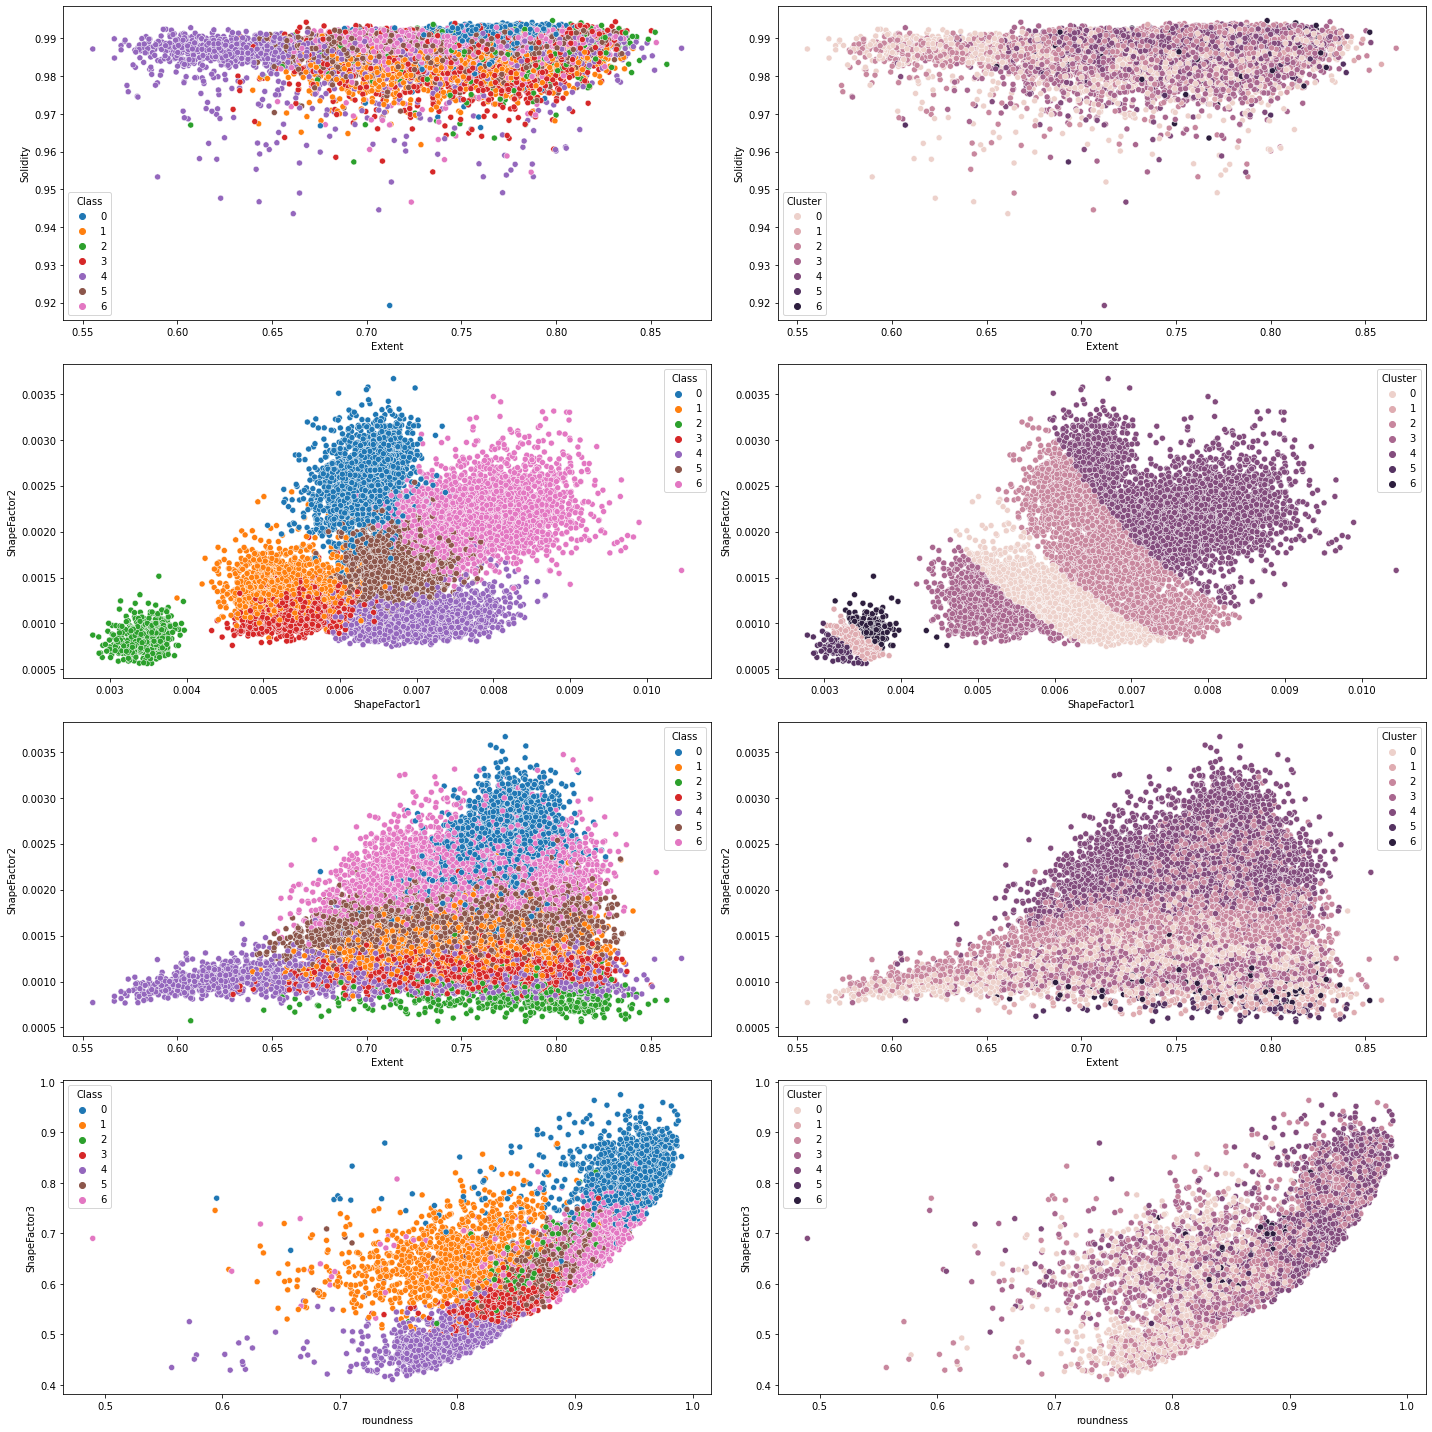

In [19]:
pandasCOD = COD.toPandas()
#print(pandasCOD.dtypes)
#pandasCOD['prediction'] = pandasCOD['prediction'].astype(object)
plot_graph(pandasCOD)

From graphs we can see Grand Truth vs. Cluster results for OD.

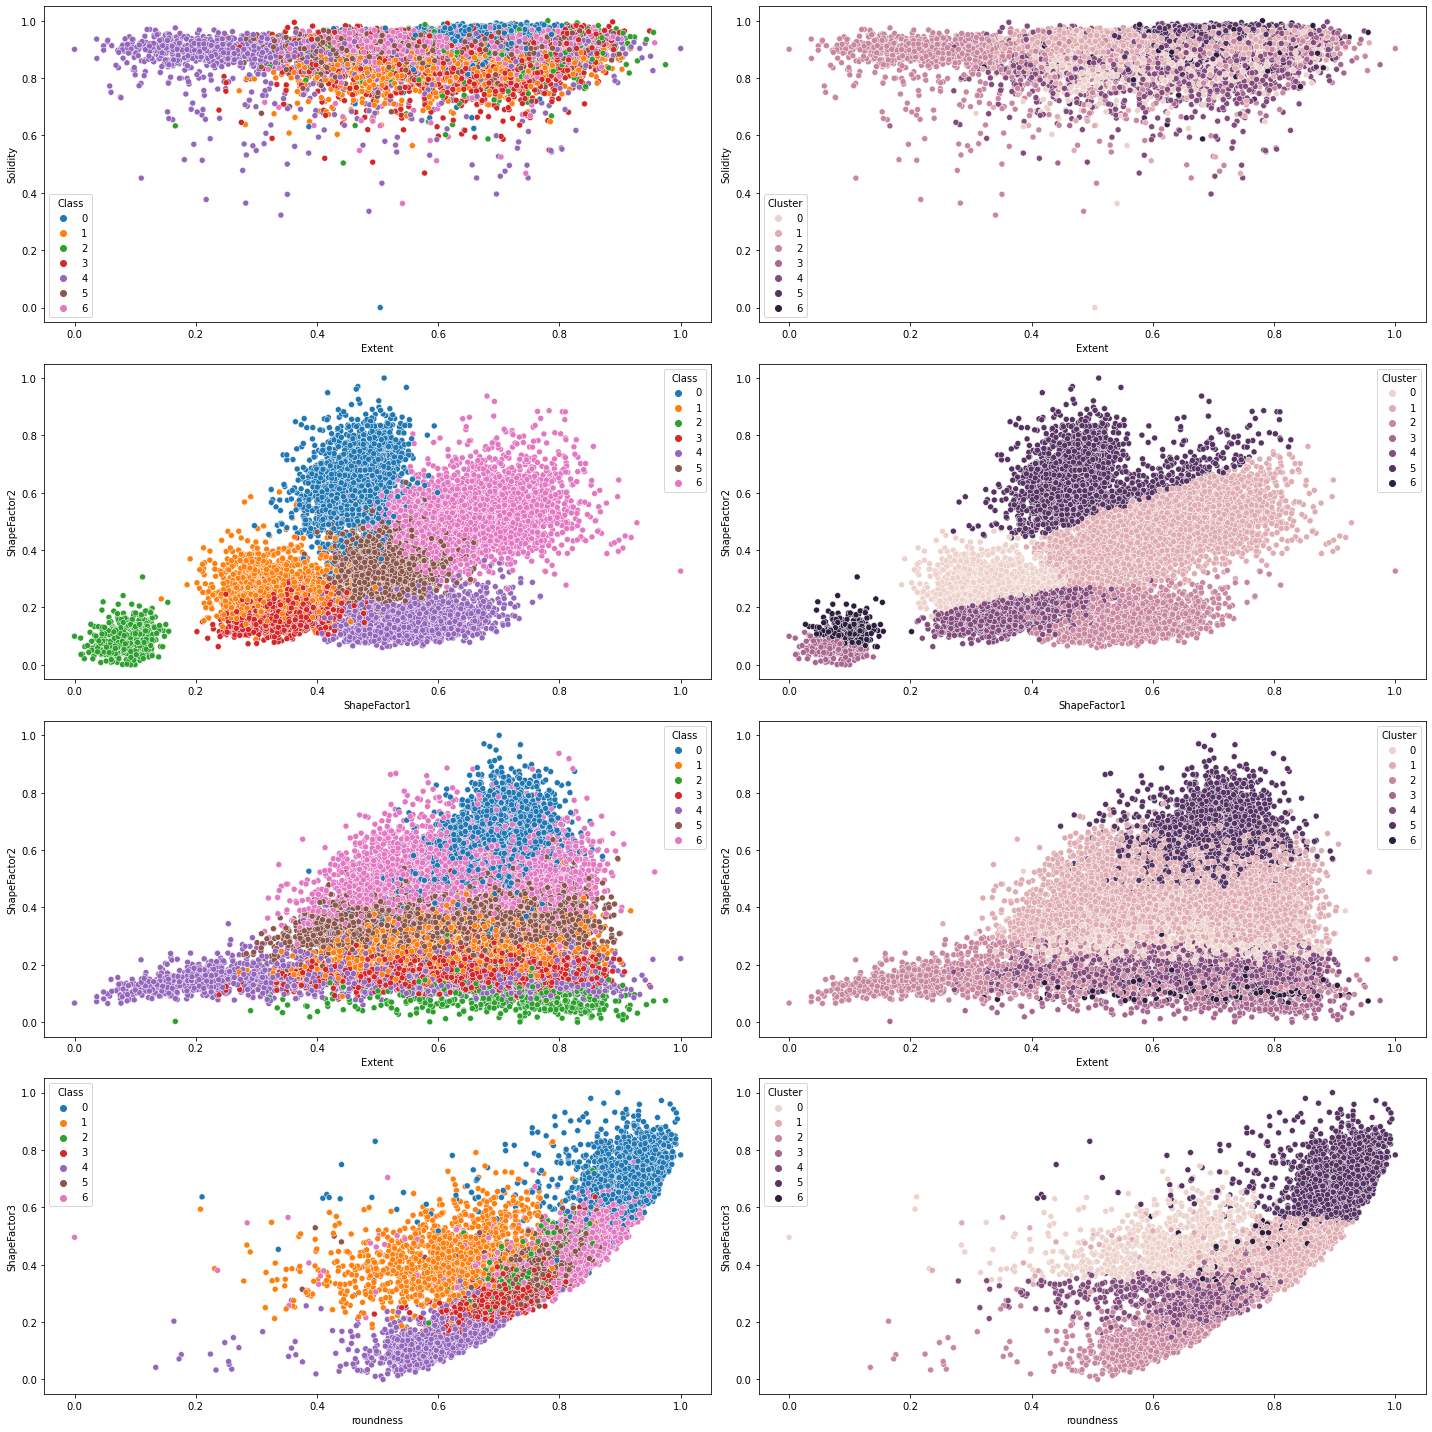

In [20]:
pandasCND = CND.toPandas()
plot_graph(pandasCND)

Grand Truth vs. Cluster results for ND. Now we can see normalization has a effect on cluster results.

In [21]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    confusion_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 

For Clustering Purity Score is selected to measure results. To calculate Purity, We assign a label to each cluster based on the most frequent class in it. Then the purity becomes the number of correctly matched class and cluster labels divided by the number of total data points.

In [22]:
print("COD Purity Score")
print(purity_score(pandasCOD["Class"],pandasCOD["Cluster"]))
print("CND Purity Score")
print(purity_score(pandasCND["Class"],pandasCND["Cluster"]))

COD Purity Score
0.6020822565162814
CND Purity Score
0.717935464815772


Normalization helped to increase our purity which is good


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

We selected Random Forest for the Classification. To perfom RF, again we crated new dataframes only contains featues and target labels

In [23]:
from pyspark.ml.classification import RandomForestClassifier
assembler_cod = VectorAssembler(inputCols = columns, 
                            outputCol="features")
COD = assembler_cod.transform(COD)
COD.show(vertical=True)

-RECORD 0-------------------------------
 Area            | 36986                
 Perimeter       | 693.771              
 MajorAxisLength | 232.7137695          
 MinorAxisLength | 202.5916367          
 AspectRation    | 1.148683989          
 Eccentricity    | 0.492059713          
 ConvexArea      | 37350                
 EquivDiameter   | 217.0069994          
 Extent          | 0.771747522          
 Solidity        | 0.990254351          
 roundness       | 0.965639328          
 Compactness     | 0.932506056          
 ShapeFactor1    | 0.006291942          
 ShapeFactor2    | 0.00293475           
 ShapeFactor3    | 0.869567545          
 ShapeFactor4    | 0.998858317          
 Class           | 0                    
 Cluster         | 4                    
 features        | [36986.0,693.771,... 
-RECORD 1-------------------------------
 Area            | 40587                
 Perimeter       | 746.02               
 MajorAxisLength | 262.969584           
 MinorAxisLength

In [24]:
assembler_cnd = VectorAssembler(inputCols = columns, 
                            outputCol="features")
CND = assembler_cnd.transform(CND)
CND.show(vertical=True)

-RECORD 0-------------------------------
 Area            | 0.07073562315325622  
 Perimeter       | 0.11572714314468924  
 MajorAxisLength | 0.08844990448992979  
 MinorAxisLength | 0.23714048068298166  
 AspectRation    | 0.08809802924680932  
 Eccentricity    | 0.3943965479427062   
 ConvexArea      | 0.06870395791851659  
 EquivDiameter   | 0.13663086278294767  
 Extent          | 0.6961942161308556   
 Solidity        | 0.9413619216616631   
 roundness       | 0.9500145393687995   
 Compactness     | 0.8419591267703701   
 ShapeFactor1    | 0.45795093961337424  
 ShapeFactor2    | 0.764505516796778    
 ShapeFactor3    | 0.8136174995777011   
 ShapeFactor4    | 0.9832027886107397   
 Class           | 0                    
 Cluster         | 5                    
 features        | [0.07073562315325... 
-RECORD 1-------------------------------
 Area            | 0.08611163299116976  
 Perimeter       | 0.1514985958152419   
 MajorAxisLength | 0.14293945824165621  
 MinorAxisLength

In [25]:
from pyspark.sql.types import IntegerType
rf_cnd = CND.select(["features", "Cluster"])
rf_cnd = rf_cnd.withColumn("Cluster", rf_cnd["Cluster"].cast(IntegerType()))
rf_cnd.show()

+--------------------+-------+
|            features|Cluster|
+--------------------+-------+
|[0.07073562315325...|      5|
|[0.08611163299116...|      5|
|[0.11350748945327...|      1|
|[0.19259936121880...|      0|
|[0.20254829288288...|      0|
|[0.20276178927052...|      0|
|[0.21276622999538...|      0|
|[0.21304377529932...|      0|
|[0.22302259645766...|      4|
|[0.23301422739927...|      0|
|[0.24222019163435...|      0|
|[0.24764299988044...|      4|
|[0.27610633828075...|      0|
|[0.56532135476267...|      6|
|[0.57998428666586...|      6|
|[0.70318878204580...|      6|
|[0.70965345266358...|      3|
|[0.20473022596457...|      4|
|[0.25009820833831...|      4|
|[0.26013253855744...|      4|
+--------------------+-------+
only showing top 20 rows



In [26]:
rf_cod = COD.select(["features", "Cluster"])
rf_cod = rf_cod.withColumn("Cluster", rf_cod["Cluster"].cast(IntegerType()))
rf_cod.show()

+--------------------+-------+
|            features|Cluster|
+--------------------+-------+
|[36986.0,693.771,...|      4|
|[40587.0,746.02,2...|      2|
|[47003.0,821.301,...|      2|
|[65526.0,992.787,...|      0|
|[67856.0,1036.144...|      0|
|[67906.0,1076.897...|      0|
|[70249.0,1056.843...|      3|
|[70314.0,1019.184...|      3|
|[72651.0,1068.024...|      3|
|[74991.0,1138.087...|      3|
|[77147.0,1158.937...|      3|
|[78417.0,1114.515...|      3|
|[85083.0,1129.571...|      3|
|[152816.0,1455.52...|      6|
|[156250.0,1509.42...|      6|
|[185104.0,1607.62...|      1|
|[186618.0,1640.61...|      1|
|[68367.0,1017.312...|      0|
|[78992.0,1106.05,...|      3|
|[81342.0,1096.012...|      3|
+--------------------+-------+
only showing top 20 rows



In [27]:
rf_od = OD.select(["features", "Class"])
rf_od = rf_od.withColumn("Class", rf_od["Class"].cast(IntegerType()))
rf_od.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[36986.0,693.771,...|    0|
|[40587.0,746.02,2...|    0|
|[47003.0,821.301,...|    1|
|[65526.0,992.787,...|    1|
|[67856.0,1036.144...|    1|
|[67906.0,1076.897...|    1|
|[70249.0,1056.843...|    1|
|[70314.0,1019.184...|    1|
|[72651.0,1068.024...|    1|
|[74991.0,1138.087...|    1|
|[77147.0,1158.937...|    1|
|[78417.0,1114.515...|    1|
|[85083.0,1129.571...|    1|
|[152816.0,1455.52...|    2|
|[156250.0,1509.42...|    2|
|[185104.0,1607.62...|    2|
|[186618.0,1640.61...|    2|
|[68367.0,1017.312...|    3|
|[78992.0,1106.05,...|    3|
|[81342.0,1096.012...|    3|
+--------------------+-----+
only showing top 20 rows



In [28]:
rf_nd = ND.select(["features", "Class"])
rf_nd = rf_nd.withColumn("Class", rf_nd["Class"].cast(IntegerType()))
rf_nd.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.07073562315325...|    0|
|[0.08611163299116...|    0|
|[0.11350748945327...|    1|
|[0.19259936121880...|    1|
|[0.20254829288288...|    1|
|[0.20276178927052...|    1|
|[0.21276622999538...|    1|
|[0.21304377529932...|    1|
|[0.22302259645766...|    1|
|[0.23301422739927...|    1|
|[0.24222019163435...|    1|
|[0.24764299988044...|    1|
|[0.27610633828075...|    1|
|[0.56532135476267...|    2|
|[0.57998428666586...|    2|
|[0.70318878204580...|    2|
|[0.70965345266358...|    2|
|[0.20473022596457...|    3|
|[0.25009820833831...|    3|
|[0.26013253855744...|    3|
+--------------------+-----+
only showing top 20 rows



The Random Forest algorithm is an algorithm for machine learning, which is a forest. We know the forest consists of a number of trees. The trees being mentioned here are decision trees. Therefore, the RF algorithm comprises a random collection or a random selection of a forest tree. It is an addition to the decision tree algorithm. So basically, what a RF algorithm does is that it creates a random sample of multiple decision trees and merges them together to obtain a more stable and accurate prediction through cross validation. So we decided to use Random Forest. We set numTrees(number of trees) to 5 and maxDepth to 5 and 10 separately.

## Evaluation<a class="anchor" id="evaluation"></a>

In [29]:
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
import matplotlib.pyplot as plt
from matplotlib import pyplot
# evaluate the model using a given test condition
od_train4, od_test4 = rf_od.randomSplit([0.75, 0.25], seed=42)
od_train5, od_test5 = rf_od.randomSplit([0.8, 0.2], seed=42)

nd_train4, nd_test4 = rf_nd.randomSplit([0.75, 0.25], seed=42)
nd_train5, nd_test5 = rf_nd.randomSplit([0.8, 0.2], seed=42)

cod_train4, cod_test4 = rf_cod.randomSplit([0.75, 0.25], seed=42)
cod_train5, cod_test5 = rf_cod.randomSplit([0.8, 0.2], seed=42)

cnd_train4, cnd_test4 = rf_cnd.randomSplit([0.75, 0.25], seed=42)
cnd_train5, cnd_test5 = rf_cnd.randomSplit([0.8, 0.2], seed=42)

def evaluate_model(df, name):
    # get the dataset
    folds = range(4,6)

    for k in folds:
        #numFolds = 5
        
        if(name == "CND" or name == "COD"):
            rf = RandomForestClassifier(labelCol="Cluster", featuresCol="features")
            evaluator = MulticlassClassificationEvaluator().setLabelCol("Cluster") 
        else:
            rf = RandomForestClassifier(labelCol="Class", featuresCol="features")
            evaluator = MulticlassClassificationEvaluator().setLabelCol("Class")   


        pipeline = Pipeline(stages=[rf])
        paramGrid = (ParamGridBuilder() 
            .addGrid(rf.numTrees, [5])
            .addGrid(rf.maxDepth, [5,10])
            .build())

        crossval = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=k)

        model = crossval.fit(df)
        if(k == 4):
            if(name == "COD"):
                predictions = model.transform(cod_test4)
            elif(name == "CND"):
                predictions = model.transform(cnd_test4)
            elif(name == "ND"):
                predictions = model.transform(nd_test4)
            elif(name == "OD"):
                predictions = model.transform(od_test4)
        if(k == 5):
            if(name == "COD"):
                predictions = model.transform(cod_test5)
            elif(name == "CND"):
                predictions = model.transform(cnd_test4)
            elif(name == "ND"):
                predictions = model.transform(nd_test5)
            elif(name == "OD"):
                predictions = model.transform(od_test5)
        
        if(name == "CND" or name == "COD"):
            score = MulticlassClassificationEvaluator(labelCol="Cluster").evaluate(predictions)
        else:
            score = MulticlassClassificationEvaluator(labelCol="Class").evaluate(predictions)
        params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]
        print("Number of Folds: "+ str(k))
        print(pd.DataFrame.from_dict([
            {model.getEvaluator().getMetricName(): metric, **ps} 
            for ps, metric in zip(params, model.avgMetrics)
        ]))
        
        if(k==4):
            data = predictions.toPandas()
            if(name == "CND" or name == "COD"):
                cf_matrix = confusion_matrix(data["Cluster"], data["prediction"])
                print(classification_report(data["Cluster"], data["prediction"], digits=3))
            else:
                cf_matrix = confusion_matrix(data["Class"], data["prediction"])
                print(classification_report(data["Class"], data["prediction"], digits=3))
            ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

            ax.set_title(name +' Confusion Matrix\n');
            ax.set_xlabel('\nPredicted Values')
            ax.set_ylabel('Actual Values ');

        ## Ticket labels - List must be in alphabetical order
        #ax.xaxis.set_ticklabels(['False','True'])
        #ax.yaxis.set_ticklabels(['False','True'])

        ## Display the visualization of the Confusion Matrix.
            

    # plot the ideal case in a separate color
    pyplot.show()


Due to slow calcutalion we only experienced 4 and 5 folds. For 4 folds all metrics are printed. 

Number of Folds: 4
         f1  numTrees  maxDepth
0  0.884260         5         5
1  0.912014         5        10
              precision    recall  f1-score   support

           0      0.977     0.975     0.976       522
           1      0.942     0.924     0.933       331
           2      1.000     0.993     0.996       143
           3      0.935     0.939     0.937       396
           4      0.988     0.962     0.974       495
           5      0.900     0.906     0.903       625
           6      0.937     0.952     0.944       900

    accuracy                          0.946      3412
   macro avg      0.954     0.950     0.952      3412
weighted avg      0.946     0.946     0.946      3412

Number of Folds: 5
         f1  numTrees  maxDepth
0  0.881888         5         5
1  0.915052         5        10


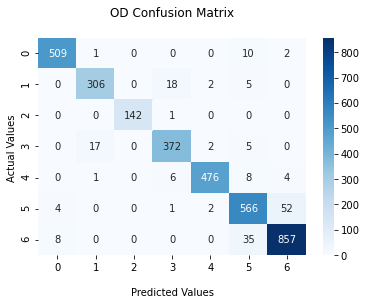

In [30]:
evaluate_model(rf_od, "OD")

Number of Folds: 4
         f1  numTrees  maxDepth
0  0.879621         5         5
1  0.914356         5        10
              precision    recall  f1-score   support

           0      0.974     0.972     0.973       470
           1      0.949     0.897     0.922       329
           2      1.000     1.000     1.000       116
           3      0.917     0.944     0.930       410
           4      0.975     0.964     0.970       448
           5      0.895     0.915     0.905       636
           6      0.945     0.943     0.944       897

    accuracy                          0.942      3306
   macro avg      0.951     0.948     0.949      3306
weighted avg      0.943     0.942     0.942      3306

Number of Folds: 5
         f1  numTrees  maxDepth
0  0.884093         5         5
1  0.913361         5        10


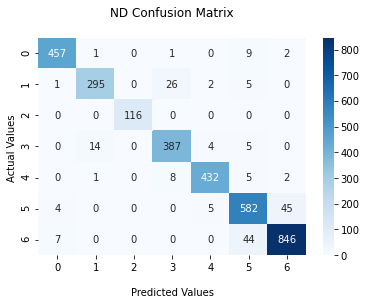

In [31]:
evaluate_model(rf_nd, "ND")

As expected OD and ND produces same results. Because Random Forest does not care about normalizaiton. Increse of max depth in tree gives us a better results. From numbers of folds persfective, there is a tiny difference between 4 and 5 folds.

Number of Folds: 4
         f1  numTrees  maxDepth
0  0.942630         5         5
1  0.964209         5        10
              precision    recall  f1-score   support

           0      0.954     0.982     0.967       544
           1      0.866     0.986     0.922        72
           2      0.981     0.991     0.986      1179
           3      1.000     0.955     0.977       444
           4      0.995     0.988     0.992      1099
           5      1.000     1.000     1.000        21
           6      0.977     0.792     0.875        53

    accuracy                          0.981      3412
   macro avg      0.967     0.956     0.960      3412
weighted avg      0.981     0.981     0.981      3412

Number of Folds: 5
         f1  numTrees  maxDepth
0  0.944223         5         5
1  0.963341         5        10


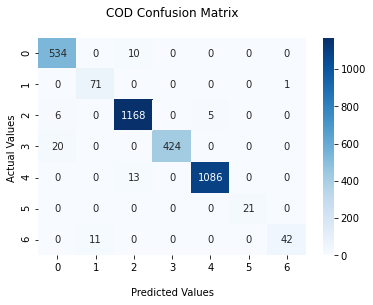

In [32]:
evaluate_model(rf_cod, "COD")

Number of Folds: 4
         f1  numTrees  maxDepth
0  0.951418         5         5
1  0.969014         5        10
              precision    recall  f1-score   support

           0      0.978     0.978     0.978       273
           1      0.996     0.991     0.994      1395
           2      0.984     0.996     0.990       446
           3      0.966     0.983     0.974        58
           4      0.985     0.981     0.983       531
           5      0.984     0.993     0.988       545
           6      0.982     0.966     0.974        58

    accuracy                          0.989      3306
   macro avg      0.982     0.984     0.983      3306
weighted avg      0.989     0.989     0.989      3306

Number of Folds: 5
         f1  numTrees  maxDepth
0  0.950702         5         5
1  0.972155         5        10


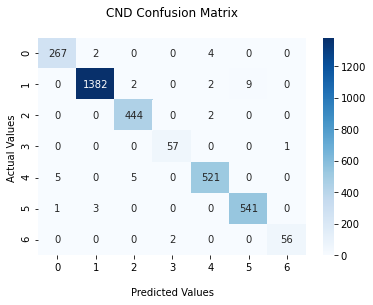

In [33]:
evaluate_model(rf_cnd, "CND")

We can see clustering helped us to increase scores. Again increase in max depth produces better results. 
Normalization for clustering was contributed to the improvement of our purity score. With more pure clusters, CND produces better results aganist COD.

## References<a class="anchor" id="references"></a>

https://spark.apache.org/docs/latest/api/python/

https://app.datacamp.com/learn/courses/cleaning-data-with-pyspark


**Disclaimer!** <font color='grey'>This notebook was prepared by <Özhan Taşdemir, Ömer Faruk Gümüş> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>